In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Mars elevation - MOLA

In [5]:
mars_elevation = pd.read_csv('mola_16ppd_elevation.csv')
print(mars_elevation.shape)
mars_elevation.head()

(317060, 4)


,OID,Latitude,Longitude,MOLA 128ppd Elevation
0,1,-10.03125,259.59375,7538.0
1,2,-10.03125,259.65625,7525.0
2,3,-10.03125,259.71875,7516.0
3,4,-10.03125,259.78125,7514.0
4,5,-10.03125,259.84375,7515.0


In [6]:
try:
    import pycpt
    
    topocmap = pycpt.load.cmap_from_cptcity_url('wkp/schwarzwald/wiki-schwarzwald-cont.cpt')
except:
    topocmap = 'Spectral_r'

### Original data/information

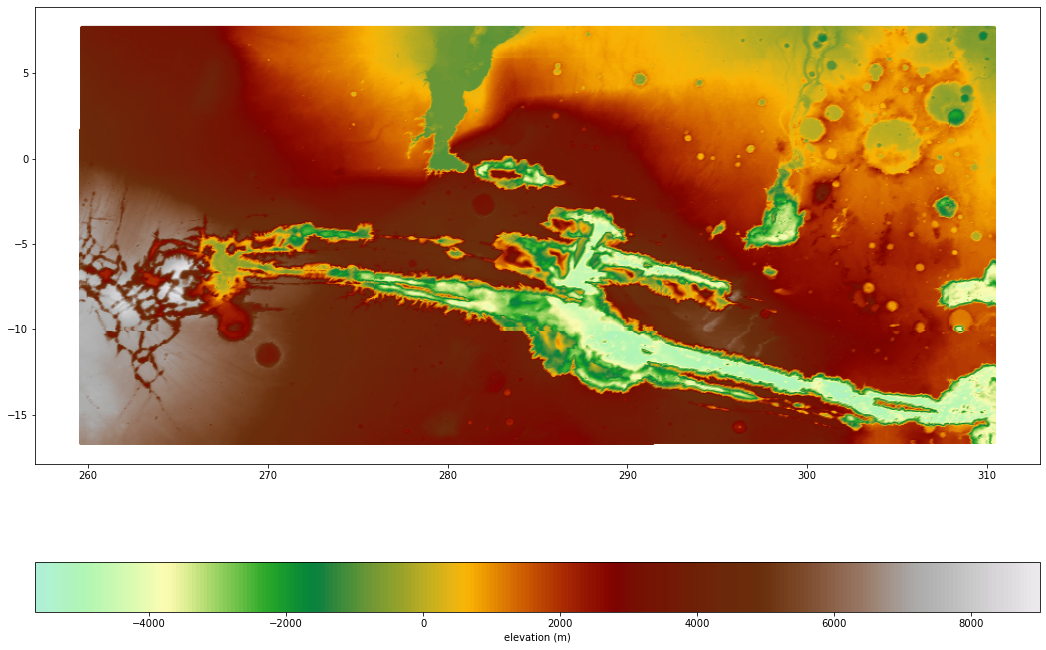

In [7]:
c_value = mars_elevation['MOLA 128ppd Elevation'] # actually, it was resampled to 16ppd

plt.figure(figsize = (18, 12))
plt.scatter(mars_elevation.Longitude, mars_elevation.Latitude, c = c_value, cmap = topocmap, marker = '.')
plt.colorbar(label = u'elevation (m)', orientation = 'horizontal')
plt.savefig('study_area.png', dpi = 400, bbox_inches = 'tight')

## Resampling

#### Resampling regularly to 1% of the original grid

In [8]:
index = np.linspace(0, len(mars_elevation)-1, int(len(mars_elevation)*0.01), dtype = int) 
mars_elevation_resampled = mars_elevation.iloc[index]

In [9]:
mars_elevation_resampled.reset_index(inplace = True)

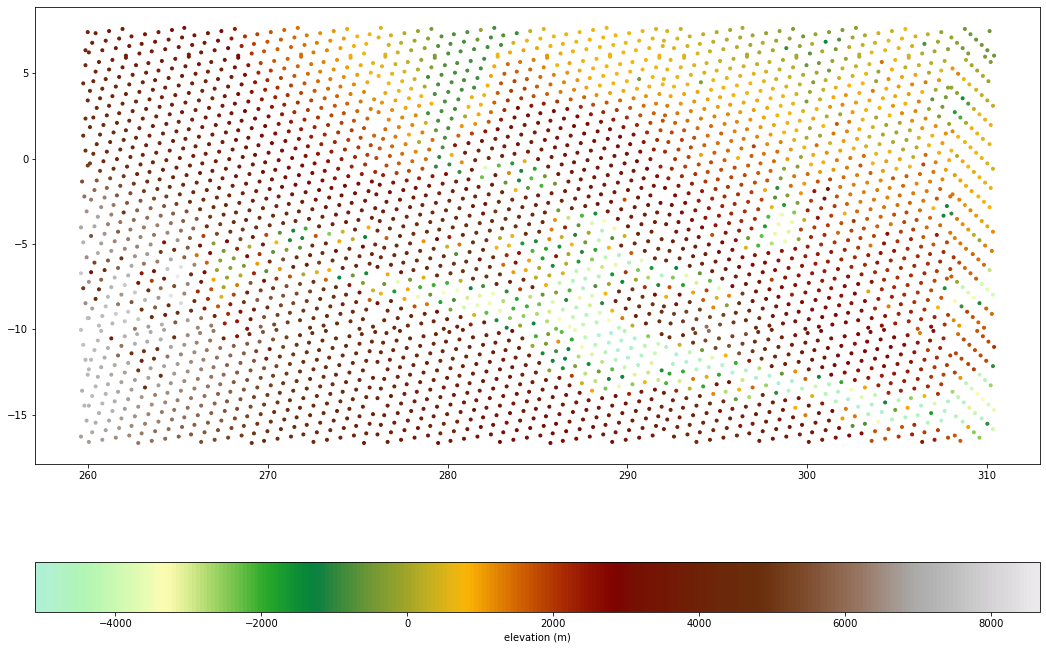

In [10]:
c_value = mars_elevation_resampled['MOLA 128ppd Elevation'] # actually, it was resampled to 16ppd

plt.figure(figsize = (18, 12))
plt.scatter(mars_elevation_resampled.Longitude, mars_elevation_resampled.Latitude,
            c = c_value, cmap = topocmap, marker = '.')
plt.colorbar(label = u'elevation (m)', orientation = 'horizontal')

In [11]:
splitting_indexes_train = np.arange(0, len(mars_elevation_resampled), 2,
                                      dtype = int)
splitting_indexes_test = np.arange(1, len(mars_elevation_resampled), 2, 
                                      dtype = int)

In [12]:
train_ = mars_elevation_resampled.iloc[splitting_indexes_train, :] #train elevation dataset
test_ = mars_elevation_resampled.iloc[splitting_indexes_test, :] #test elevation dataset

In [13]:
train_.reset_index(inplace=True)
test_.reset_index(inplace=True)

In [14]:
test_ = test_.drop('level_0', axis = 1)
train_ = train_.drop('level_0', axis = 1)

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train = train_[['Latitude', 'Longitude']].values
y_train = train_.iloc[:, 4:5].values # elevation values

x_test = test_[['Latitude', 'Longitude']].values
y_test = test_.iloc[:, 4:5].values # elevation values

x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

y_train = scaler.fit_transform(y_train)
y_test = scaler.fit_transform(y_test)

In [505]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(n_estimators = 500)

In [506]:
rf_regressor.fit(x_train, y_train)

/home/silva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(n_estimators=500)

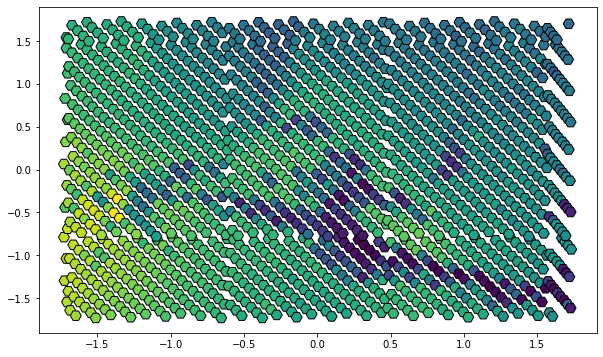

In [507]:
plt.figure(figsize = (10, 6))
plt.scatter(x_train[:, 1], x_train[:, 0], c=y_train, marker = 'H', edgecolor = 'k', s = 120)

In [508]:
Y_pred = rf_regressor.predict(x_test)

Text(0.5, 0, 'real values')

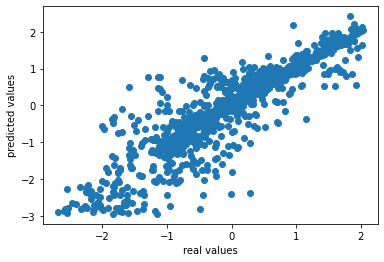

In [509]:
plt.scatter(Y_pred, y_test)
plt.ylabel('predicted values')
plt.xlabel('real values')

In [510]:
from sklearn.metrics import max_error, explained_variance_score

In [511]:
explained_variance_score_ = explained_variance_score(y_test, Y_pred)
max_error_ = max_error(y_test, Y_pred)

In [512]:
print(f'explained variance score: {explained_variance_score_} - max error: {max_error_}')

explained variance score: 0.8210528864935448 - max error: 2.673542270517269


In [532]:
test_prediction = mars_elevation[['Latitude', 'Longitude']].values
test_prediction = scaler.fit_transform(test_prediction)

In [533]:
test_prediction

array([[-0.78819063, -1.73019297],
       [-0.78819063, -1.72593538],
       [-0.78819063, -1.72167779],
       ...,
       [ 1.49701321,  1.72271167],
       [ 1.49701321,  1.72696926],
       [ 1.49701321,  1.73122685]])

In [534]:
predicted_values = rf_regressor.predict(test_prediction)
real_values = scaler.fit_transform(mars_elevation.iloc[:, 3:4].values)

In [535]:
real_values = X1 = [x for l in real_values for x in l]

### Correlation matrix

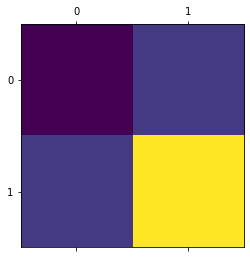

In [537]:
from numpy import cov, std
cov_matrix =  cov(predicted_values, real_values)

plt.matshow(cov_matrix)

## Person's correlation and fitted line

In [538]:
from scipy.stats import pearsonr

corr, _ = pearsonr(predicted_values, real_values)
print("Pearson's correlation: %.3f" % corr)

Pearson's correlation: 0.930


In [539]:
import scipy.stats

xy = np.array([predicted_values,  real_values])
slope, intercept, r_value, p_value, std_err  = scipy.stats.linregress(xy)

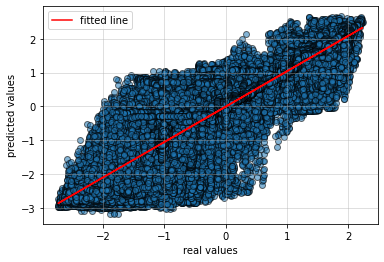

In [540]:
plt.grid(alpha = 0.5)
plt.scatter(predicted_values,  real_values, edgecolor = 'k', alpha = 0.55)
plt.plot(predicted_values, intercept + slope * predicted_values, 'r', label='fitted line')
plt.ylabel('predicted values')
plt.xlabel('real values')
plt.legend()

## Result - Random Forest Interpolation

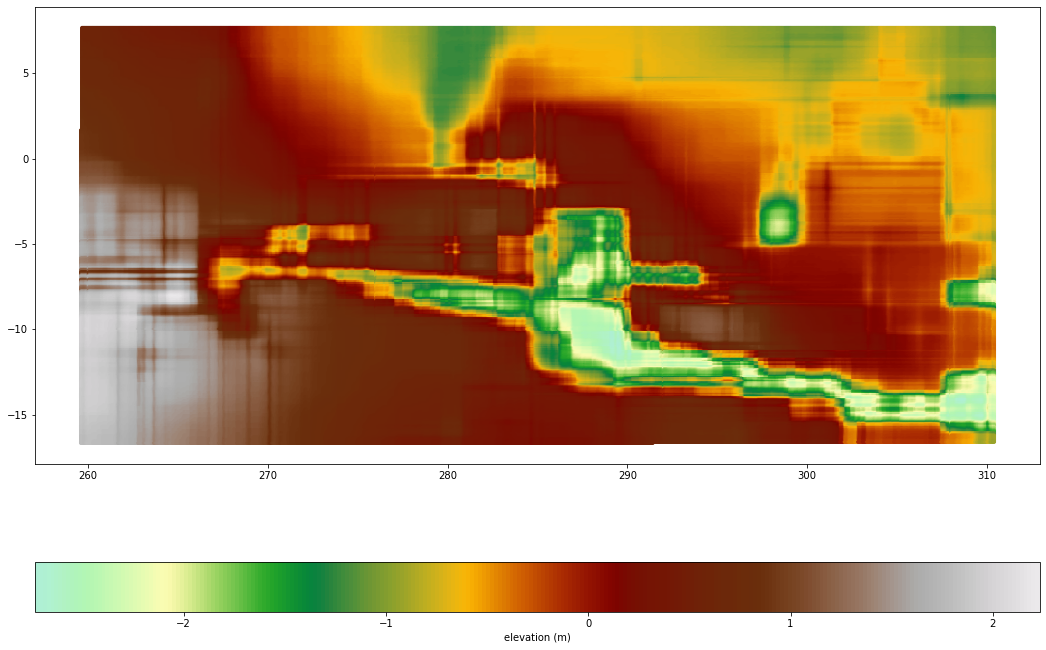

In [623]:
plt.figure(figsize = (18, 12))
plt.scatter(mars_elevation.Longitude, mars_elevation.Latitude, c = predicted_values, cmap = topocmap, marker = '.')
plt.colorbar(label = u'elevation (m)', orientation = 'horizontal')
plt.savefig('random_forest_interp', dpi = 400, bbox_inches = 'tight')

In [652]:
from sklearn.neural_network import MLPRegressor

In [775]:
neuralnet_regressor = MLPRegressor(hidden_layer_sizes = (1000,), activation = 'relu', 
                                   alpha = 0.0001, solver = 'lbfgs')

In [776]:
neuralnet_regressor.fit(x_train, y_train)

/home/silva/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/silva/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(hidden_layer_sizes=(1000,), solver='lbfgs')

In [777]:
Y_pred = neuralnet_regressor.predict(x_test)

### Perfomance metrics - Neuralnet

In [778]:
explained_variance_score_ = explained_variance_score(y_test, Y_pred)
max_error_ = max_error(y_test, Y_pred)

In [779]:
print(f'explained variance score: {explained_variance_score_} - max error: {max_error_}')

explained variance score: 0.7878864182138068 - max error: 2.4818033165762694


In [780]:
predicted_values = neuralnet_regressor.predict(test_prediction)
real_values = scaler.fit_transform(mars_elevation.iloc[:, 3:4].values)

In [781]:
real_values = X1 = [x for l in real_values for x in l]

### Pearson's coeficient

In [782]:
from scipy.stats import pearsonr

corr, _ = pearsonr(predicted_values, real_values)
print("Pearson's correlation: %.3f" % corr)

Pearson's correlation: 0.892


In [783]:
import scipy.stats

xy = np.array([predicted_values,  real_values])
slope, intercept, r_value, p_value, std_err  = scipy.stats.linregress(xy)

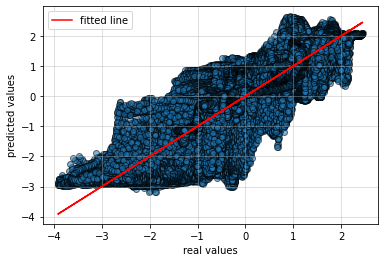

In [784]:
plt.grid(alpha = 0.5)
plt.scatter(predicted_values,  real_values, edgecolor = 'k', alpha = 0.55)
plt.plot(predicted_values, intercept + slope * predicted_values, 'r', label='fitted line')
plt.ylabel('predicted values')
plt.xlabel('real values')
plt.legend()

### Result - Neuralnet interpolation

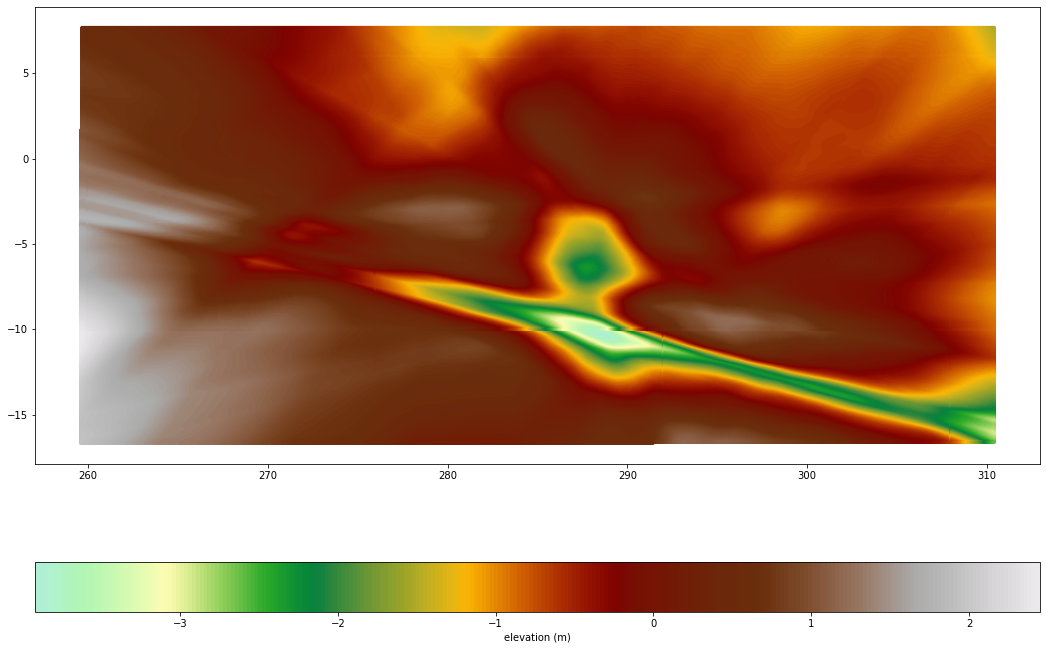

In [785]:
plt.figure(figsize = (18, 12))
plt.scatter(mars_elevation.Longitude, mars_elevation.Latitude, c = predicted_values, cmap = topocmap, marker = '.')
plt.colorbar(label = u'elevation (m)', orientation = 'horizontal')
plt.savefig('neural_network_interp', dpi = 400, bbox_inches = 'tight')

### Geostatistics

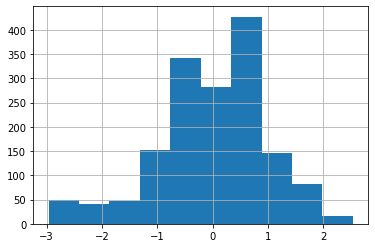

In [786]:
# histogram train dataset
plt.hist(y_train)
plt.grid(True)

In [19]:
train_std = train_.copy()
train_std['MOLA 128ppd Elevation'] = y_train

In [624]:
from skgstat import Variogram, OrdinaryKriging
from pprint import pprint

In [643]:
V = Variogram(list(zip(train_std.Latitude, train_std.Longitude)), train_std['MOLA 128ppd Elevation'], 
              normalize=False, use_nugget=True, n_lags=25, model = 'spherical', fit_sigma='sq')

env: SKG_SUPPRESS=True


/home/silva/anaconda3/lib/python3.7/site-packages/skgstat/Variogram.py:1668: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 720x576 with 0 Axes>

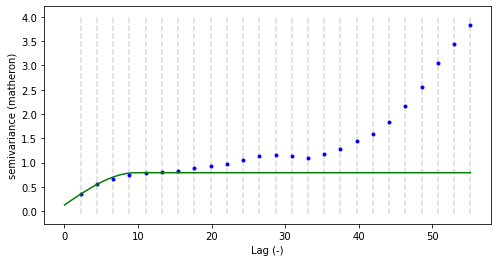

In [644]:
plt.figure(figsize=(10, 8))
V.plot(show=True, hist = False)
%set_env SKG_SUPPRESS= True

In [645]:
V.describe()

{'name': 'spherical',
 'estimator': 'matheron',
 'effective_range': 9.678505324917358,
 'sill': 0.6626051437098529,
 'nugget': 0.13081994599834906}

In [646]:
ok = OrdinaryKriging(V, min_points=5, max_points=40, mode='exact', n_jobs=1)

In [647]:
krig_values = ok.transform(mars_elevation.Latitude, mars_elevation.Longitude)
krig_s2 = ok.sigma

### Result - Ordinary Kriging ($model = spherical$) 

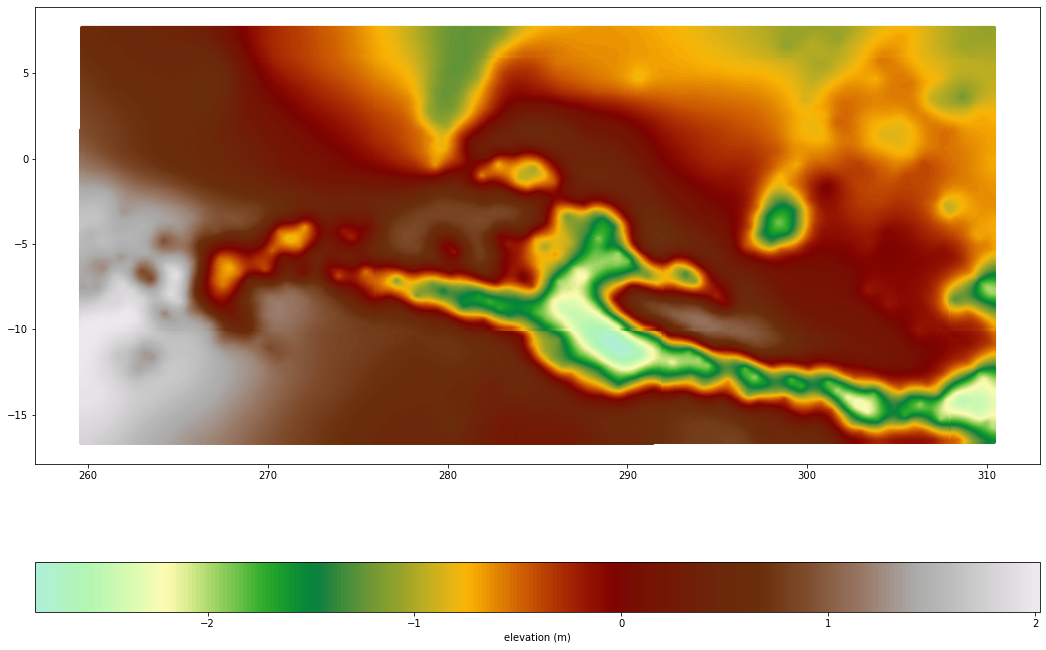

In [648]:
plt.figure(figsize = (18, 12))
plt.scatter(mars_elevation.Longitude, mars_elevation.Latitude, c = krig_values, cmap = topocmap, marker = '.')
plt.colorbar(label = u'elevation (m)', orientation = 'horizontal')
plt.savefig('krig_interp', dpi = 400, bbox_inches = 'tight')

In [649]:
from scipy.stats import pearsonr

corr, _ = pearsonr(krig_values, real_values)
print("Pearson's correlation: %.3f" % corr)

Pearson's correlation: 0.926


In [650]:
import scipy.stats

xy = np.array([krig_values,  real_values])
slope, intercept, r_value, p_value, std_err  = scipy.stats.linregress(xy)

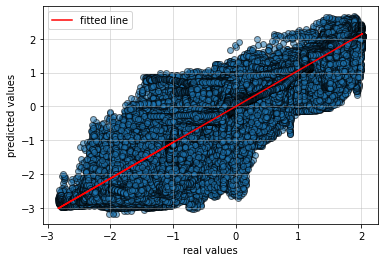

In [651]:
plt.grid(alpha = 0.5)
plt.scatter(krig_values,  real_values, edgecolor = 'k', alpha = 0.55)
plt.plot(krig_values, intercept + slope * krig_values, 'r', label='fitted line')
plt.ylabel('predicted values')
plt.xlabel('real values')
plt.legend()

## Non-geostatistical methods

In [20]:
from scipy.interpolate import griddata

In [22]:
points = train_std[['Latitude', 'Longitude']].values
values = np.array(train_std.iloc[:, 4])

In [23]:
xv = np.linspace(mars_elevation.Longitude.min(), mars_elevation.Longitude.max(), 8000)
yv = np.linspace(mars_elevation.Latitude.min(), mars_elevation.Latitude.max(), 3000)

grid_y, grid_x = np.meshgrid(yv, xv, indexing = 'ij')

In [24]:
grid_ =  griddata(points, values, (grid_y, grid_x), method = 'cubic')

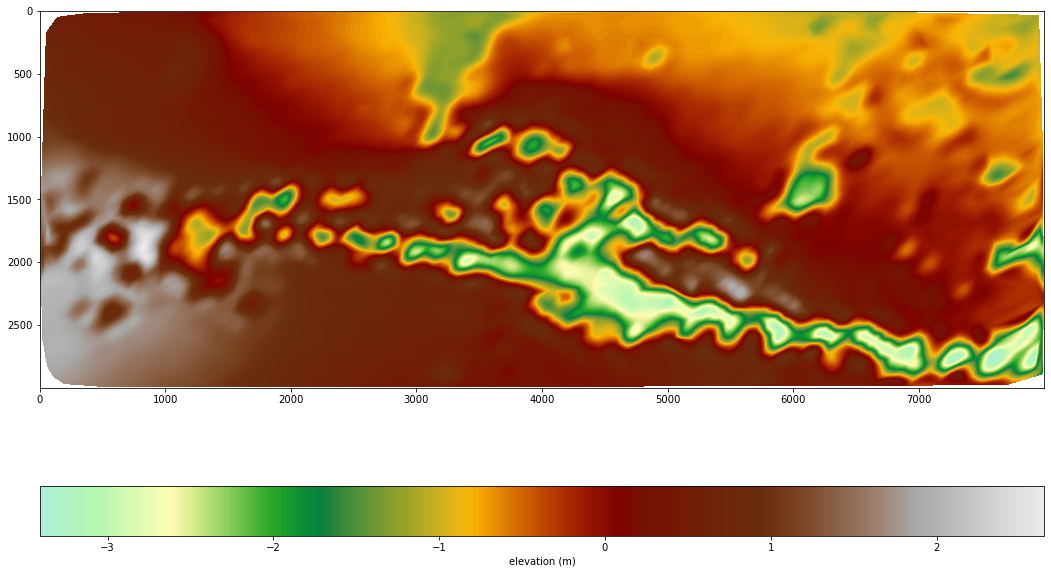

In [25]:
plt.figure(figsize = (18, 12))
plt.imshow(grid_[::-1], cmap = topocmap)
plt.colorbar(label = u'elevation (m)', orientation = 'horizontal')
plt.savefig('cubic_interp', dpi = 400, bbox_inches = 'tight')

##### Sometimes we can find the best solution with the simplest tools...